# Project: Investigate a Dataset - [No_show_appointments]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

>In this report we are going to investigate whether attending or not attending a doctor's appointment is related to multiple factors such as:
>1- Age of the patient
>2- whether the patient has a sickness or not
>3- whether the patient is living in a specific city


### Question(s) for Analysis
>1- Does Age affect the propability of attending doctor's appointment?
>2- Does having an illness affect the propability of attending doctor's appointment?
>3- Does living in a specific city affect the propability of attending doctor's appointment?


In [1]:
# Importing important packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline


In [2]:
# Upgrading pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0

Requirement already up-to-date: pandas==0.25.0 in /opt/conda/lib/python3.6/site-packages (0.25.0)


<a id='wrangling'></a>
## Data Wrangling

> Loading data and dropping unimportant values


In [3]:
# Loading data from csv file
df = pd.read_csv('no_show.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
#Undrastanding data 
df.shape

(110527, 14)

In [5]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [7]:
# Check the amount of -1 in age because it's not logical
removable = df.query("Age == '-1'")
removable

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


In [8]:
print ('1 row wouldnot affect the analysis')

1 row wouldnot affect the analysis


In [9]:
#Check Duplicated IDs
df['PatientId'].duplicated().sum()


48228


### Data Cleaning
We found out that there are no null cells in our data 
Irreasonable data are not too much so it can be disregarded
Dropping duplicated Patient IDs and the unnecessary columns for a better view of the data
 

In [10]:
#Drop Duplicated rows with similar statues
df.drop_duplicates(['PatientId', 'No-show'], inplace = True)
df.shape

(71817, 14)

In [11]:
#Drop Unnecessary columns
df.drop(['PatientId', 'AppointmentID' , 'ScheduledDay' , 'AppointmentDay'], axis = 1, inplace = True)
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4439780d30>,
      dtype=object)

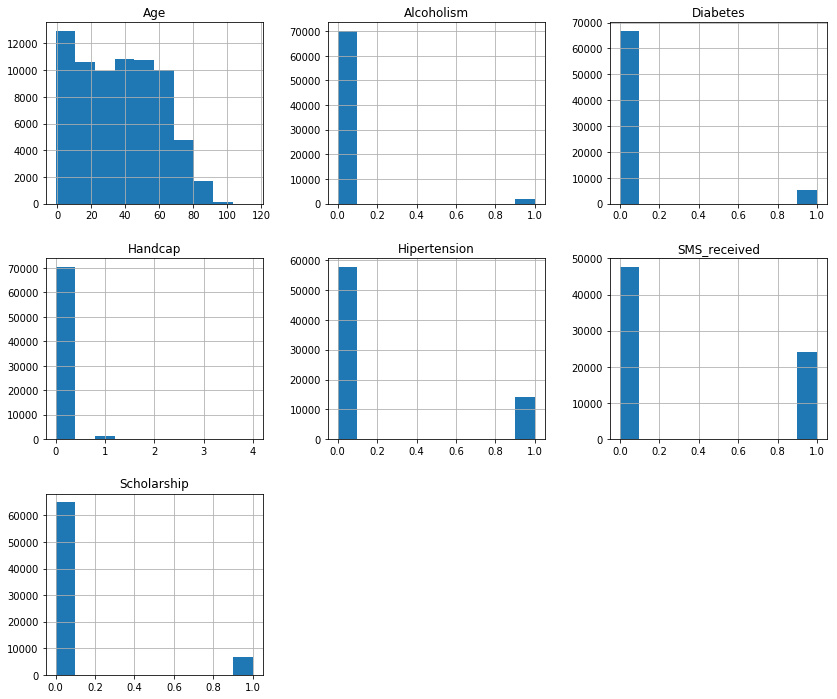

In [12]:
#General Overview of data
df.hist(figsize=(14,12))

In [13]:
#fix thename of No-Show column
df.rename(columns={"No-show" : "No_show"}, inplace = True)
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [14]:
#Devide data to two groups, those who attended and those who didn't
Attended = df.No_show == 'No'
Absent = df.No_show == 'Yes'

<a id='eda'></a>
## Exploratory Data Analysis

Deviding the data into Attended and Absent groups to identify the factors affecting their attendance


### Research Question 1 (Does Age affects Attendance?)

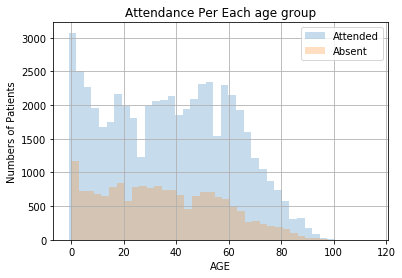

In [15]:
#check How Age affected Attendance and Absence
df.Age[Attended].mean()
df.Age[Absent].mean()

df.Age[Attended].hist(alpha=.25, bins=40, label='Attended')
df.Age[Absent].hist(alpha=0.25, bins=40, label='Absent')
plt.xlabel("AGE")
plt.ylabel("Numbers of Patients")
plt.title("Attendance Per Each age group")
plt.rcParams["figure.figsize"] = (20,8)
plt.legend();

In [16]:
print ('Younger ages are most likely to attend')

Younger ages are most likely to attend




### Research Question 2 (Are there any other factors affecting Attendance?)

In [17]:
#check How different variables affected Attendance and Absence
df[Attended].mean()

Age             37.228460
Scholarship      0.091332
Hipertension     0.202940
Diabetes         0.072866
Alcoholism       0.023599
Handcap          0.020903
SMS_received     0.297226
dtype: float64

In [18]:
df[Absent].mean()

Age             34.376267
Scholarship      0.108419
Hipertension     0.170922
Diabetes         0.065108
Alcoholism       0.029440
Handcap          0.017777
SMS_received     0.453094
dtype: float64



### Research Question 3 (Does living in a certain city affect Attendance?)

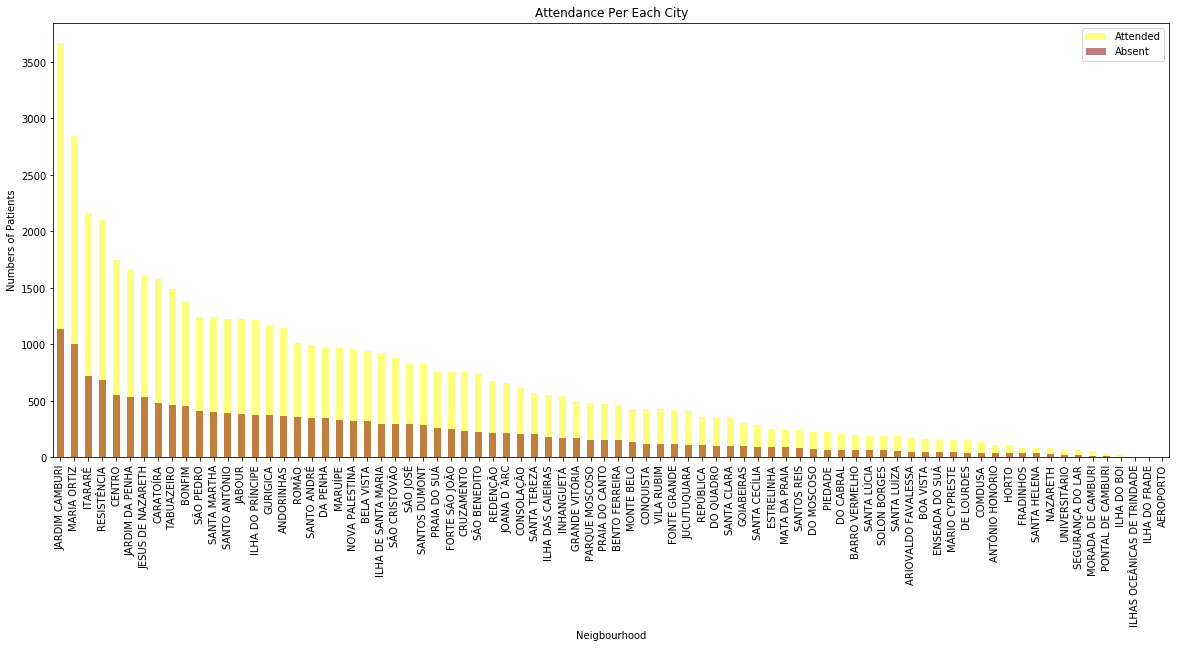

In [19]:
#Check if living in A certain neighbourhood affects attendance
df.Neighbourhood[Attended].value_counts()
df.Neighbourhood[Absent].value_counts()

df.Neighbourhood[Attended].value_counts().plot(kind='bar',alpha=.5, color= 'yellow', label='Attended', width = .5)
df.Neighbourhood[Absent].value_counts().plot(kind='bar',alpha=.5, color= 'maroon', label='Absent', width = .5)
plt.xlabel("Neigbourhood")
plt.ylabel("Numbers of Patients")
plt.title("Attendance Per Each City")
plt.rcParams["figure.figsize"] = (150,8)
plt.legend();



In [20]:
print('Neighbourhood doesent affect attendance')

Neighbourhood doesent affect attendance




### Research Question 4 (Is recieving an SMS affecting Attendance?)

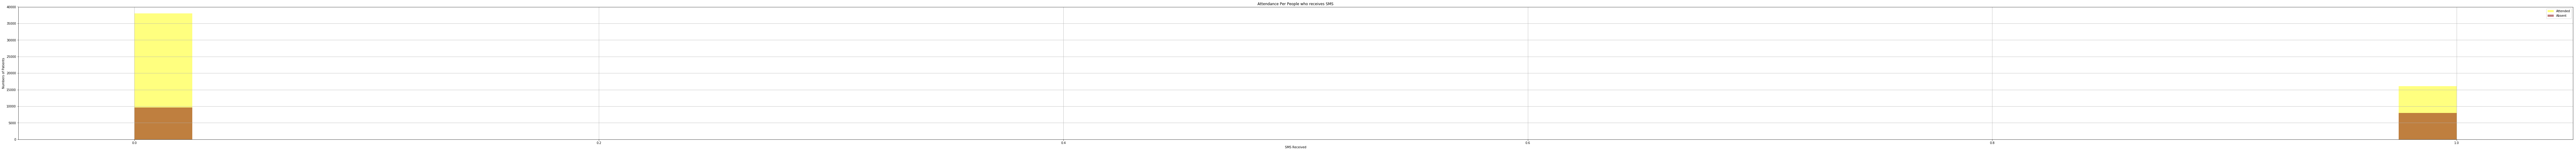

In [21]:
#check How SMS Delivery affected Attendance and Absence
df.Age[Attended].mean()
df.Age[Absent].mean()

df.SMS_received[Attended].hist(alpha=.5, bins=40, color = "yellow", label='Attended')
df.SMS_received[Absent].hist(alpha=0.5, bins=40, color= "maroon", label='Absent')
plt.xlabel("SMS Received")
plt.ylabel("Numbers of Patients")
plt.title("Attendance Per People who receives SMS")
plt.rcParams["figure.figsize"] = (1,20)
plt.legend();

### Research Question 5  (Does Diseases Affect Attendance)

In [22]:
# #check How Having diseases affected Attendance and Absence
df[Attended].groupby(['Hipertension', 'Diabetes']).mean()['Age']

Hipertension  Diabetes
0             0           30.712613
              1           53.701370
1             0           60.270517
              1           63.764303
Name: Age, dtype: float64

In [23]:
df[Absent].groupby(['Hipertension', 'Diabetes']).mean()['Age']

Hipertension  Diabetes
0             0           28.768691
              1           49.481172
1             0           58.650380
              1           62.913282
Name: Age, dtype: float64

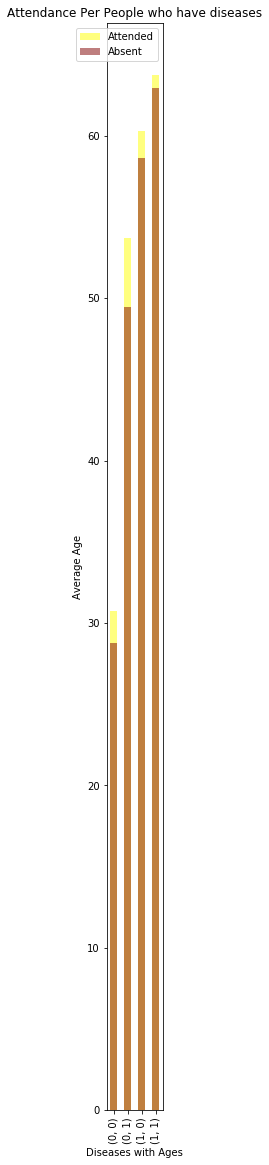

In [24]:
#Plot having chronic deseases against average ages
df[Attended].groupby(['Hipertension', 'Diabetes']).mean()['Age'].plot(kind = 'bar', alpha = 0.5, color = 'yellow', label = 'Attended')
df[Absent].groupby(['Hipertension', 'Diabetes']).mean()['Age'].plot(kind = 'bar', alpha = 0.5, color = 'maroon', label = 'Absent')
plt.xlabel("Diseases with Ages")
plt.ylabel("Average Age")
plt.title("Attendance Per People who have diseases")
plt.rcParams["figure.figsize"] = (50,10)
plt.legend();


In [25]:
print ('mean values are similar and diseases doesent affect attendance')

mean values are similar and diseases doesent affect attendance


### Research Question 6  (Does SMS Delivery and alcholism differ in result for Age groups)

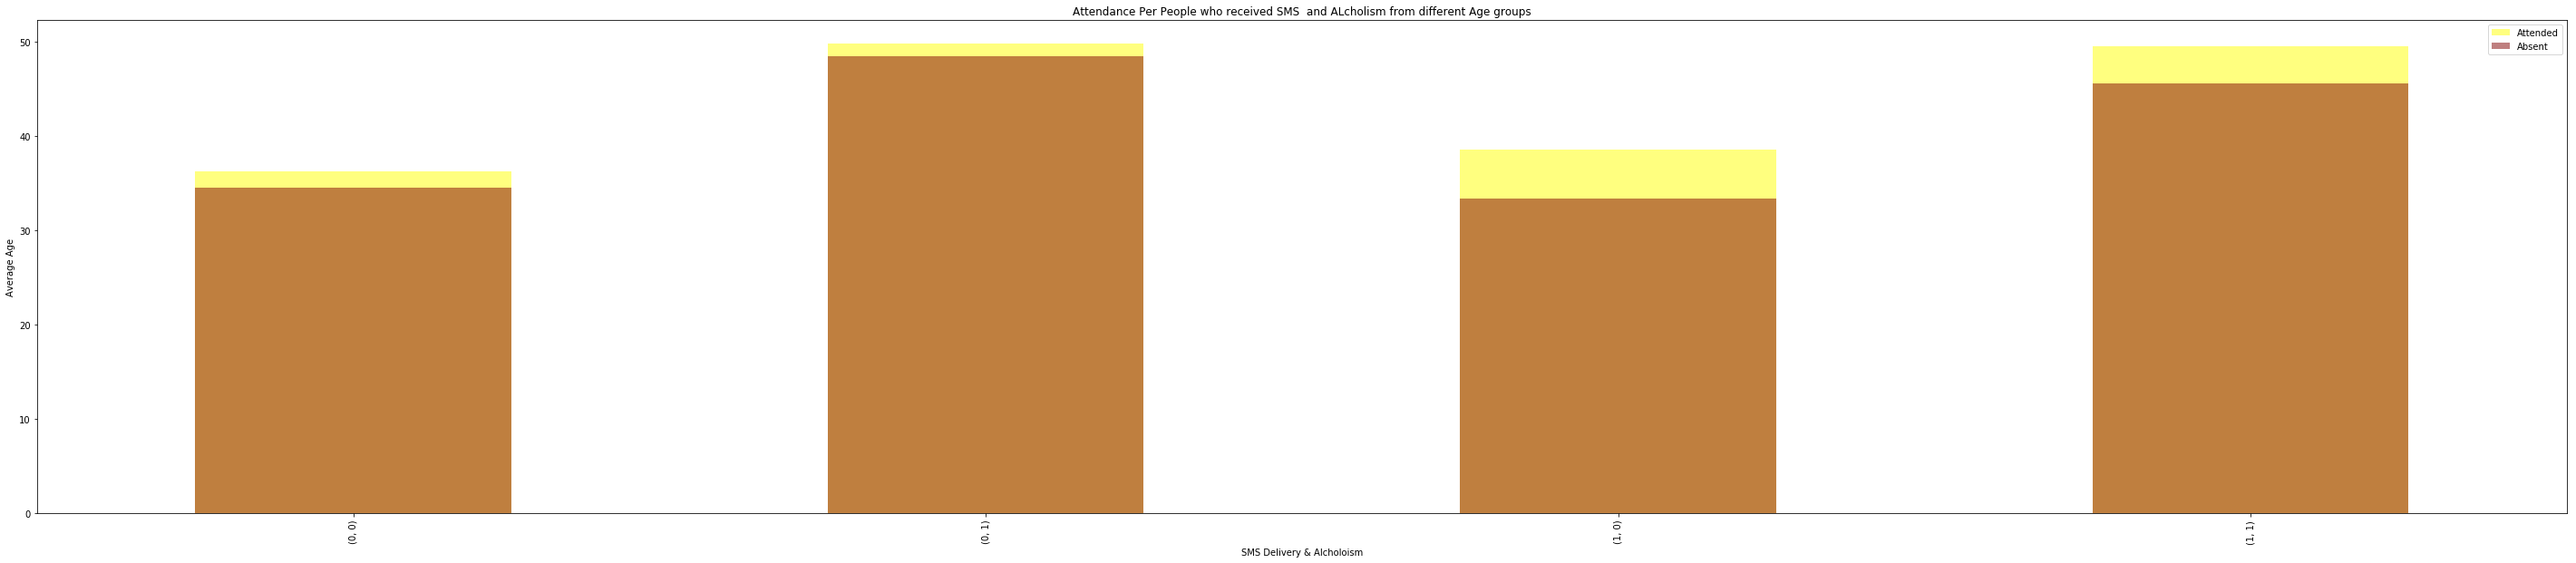

In [26]:
#Check if SMS delivery and Alcholism Combined affect attendance
df[Attended].groupby(['SMS_received', 'Alcoholism']).mean()['Age'].plot(kind = 'bar', color = 'yellow', alpha = 0.5, label = 'Attended')
df[Absent].groupby(['SMS_received', 'Alcoholism']).mean()['Age'].plot(kind = 'bar', color = 'maroon', alpha = 0.5, label = 'Absent')
plt.xlabel("SMS Delivery & Alcholoism")
plt.ylabel("Average Age")
plt.title("Attendance Per People who received SMS  and ALcholism from different Age groups")
plt.rcParams["figure.figsize"] = (20,10)
plt.legend();

<a id='conclusions'></a>
## Conclusions

It was found out that younger age groups are more likely to attend doctor appointments. n\
It was found out That SMS Delivery doesn't has a huge effect on wheter or not the patient might attend n\
It was found out that having a chronic disease is not affecting attendance. n\
It was found out that living in a certain neighbourhood doesent have a huge effect on attendance n\
It was found out that alcholoism along with sms delivery are not affecting attendance

## Submitting your Project 


In [27]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0